In [1]:
import time
from auto_robot_design.pinokla.closed_loop_kinematics import closedLoopProximalMount

from auto_robot_design.pinokla.calc_criterion import search_workspace
from pinocchio.visualize import MeshcatVisualizer
import meshcat
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

import pinocchio as pin
from auto_robot_design.pinokla.closed_loop_kinematics import ForwardK
from auto_robot_design.pinokla.closed_loop_jacobian import jacobian_constraint

from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator
%load_ext autoreload
%autoreload 2

In [2]:
gen = TwoLinkGenerator()
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE)
graphs_and_cons = gen.get_standard_set()
np.set_printoptions(precision=3, linewidth=300, suppress=True, threshold=10000)

graph_jp, cons_dict = graphs_and_cons[11]

In [ ]:
# robo, robo_free = jps_graph2pinocchio_robot(graph_jp, builder)

# q0 = closedLoopProximalMount(
#     robo.model,
#     robo.data,
#     robo.constraint_models,
#     robo.constraint_data,
#     max_it=100,
# )

In [3]:
# viz = MeshcatVisualizer(robo.model, robo.visual_model, robo.visual_model)
# # viz.viewer = meshcat.Visualizer().open()
# # viz.clean()
# # viz.loadViewerModel()
# viz.initViewer(loadModel=True)
# viz.display(q0)

NameError: name 'robo' is not defined

In [ ]:
def jacobian_constraint_custom(model,data,constraint_model,constraint_data,actuation_model,q0):
    #update of the jacobian an constraint model
    # pin.computeJointJacobians(model,data,q0)
    cdatas = pin.StdVec_RigidConstraintData()
    cmodels = pin.StdVec_RigidConstraintModel()
    for cm,cd in zip(constraint_model,constraint_data):
        cdatas.append(cd)
        cmodels.append(cm)
    Jright = pin.getConstraintsJacobian(model,data,cmodels,cdatas)
    

    LJ=[np.array(())]*len(constraint_model)
    for (cm,cd,i) in zip(constraint_model,constraint_data,range(len(LJ))):
        LJ[i]=pin.getConstraintJacobian(model,data,cm,cd)
        

    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv=model.nv
    nv_mot=len(Lidmot)
    nv_free=len(Lidfree)
    Lnc=[J.shape[0] for J in LJ]
    nc=int(np.sum(Lnc))
    
    
    Jmot=np.zeros((nc,nv_mot))
    Jfree=np.zeros((nc,nv_free))
    
    #separation between Jmot and Jfree
    nprec=0
    for J,n in zip(LJ,Lnc):
        Smot=np.zeros((nv,nv_mot))
        Smot[Lidmot,range(nv_mot)]=1
        Sfree=np.zeros((nv,nv_free))
        Sfree[Lidfree,range(nv_free)]=1

        Jmot[nprec:nprec+n,:]=J@Smot
        Jfree[nprec:nprec+n,:]=J@Sfree

        nprec=nprec+n
    
    #act2pass?
    # E_tau = np.zeros((nv, nv))
    # E_tau[range(nv_mot), Lidmot] = 1
    # E_tau[range(nv_mot,nv), Lidfree] = 1
    # # computation of dq/dqmot
    # pinvJfree=np.linalg.pinv(Jfree)
    # dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot))
    # #re order dq/dqmot
    # dq_dmot=dq_dmot_no.copy()
    # dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    # dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]
    # return dq_dmot_no, E_tau
    
    return (Jmot, Jfree), Jright

In [ ]:
def jacobian_closed(model,data,constraint_model,constraint_data,actuation_model,q0, ideff):
    Jmot, Jfree = jacobian_constraint(model,data,constraint_model,constraint_data,actuation_model,q0) # q0 does nothing here

    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv_mot=len(Lidmot)

    # computation of dq/dqmot
    pinvJfree=np.linalg.pinv(Jfree)
    dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot)) 
    # DOES NOT CHANGE DURING SIM
    
    #re order dq/dqmot
    dq_dmot=dq_dmot_no.copy()
    dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]
    
    #computation of the closed-loop jacobian
    # Jf_closed = pin.computeFrameJacobian(model,data,q0,ideff,pin.LOCAL)@dq_dmot
    Jf_closed = pin.computeFrameJacobian(model,data,q0,ideff,pin.LOCAL_WORLD_ALIGNED)@dq_dmot
    return Jf_closed

In [ ]:
def calc_dqdmot(Jmot, Jfree, actuation_model):
    #init of constant
    Lidmot=actuation_model.idvmot
    Lidfree=actuation_model.idvfree
    nv_mot=len(Lidmot)

    # computation of dq/dqmot
    pinvJfree=np.linalg.pinv(Jfree)
    dq_dmot_no=np.concatenate((np.identity(nv_mot),-pinvJfree@Jmot)) 
    
    #re order dq/dqmot
    dq_dmot=dq_dmot_no.copy()
    dq_dmot[Lidmot]=dq_dmot_no[:nv_mot,:]
    dq_dmot[Lidfree]=dq_dmot_no[nv_mot:,:]
    return dq_dmot

In [ ]:
def Jcl_toXZ_svds(Jclosed):
    Jclosed = Jclosed[(0,2),:]
    Jinv = np.linalg.pinv(Jclosed)
    U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)

    # Jinv = np.linalg.pinv(Jclosed)
    # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
    # # print('cut',Jclosed[(0,2),:])
    # # print('svd',np.dot(U[(0,2),:]*S, Vh))
    # # print('invsvdf', np.dot(U2*S2, Vh2)[:,(0,2)])
    # U = U[(0,2),:]
    # Vh2 = Vh2[:,(0,2)]
    # # print('svdcut',np.dot(U*S, Vh))

    # Jclosed = Jclosed[(0,2),:]
    # # print('invcut',Jinv[:,(0,2)])
    # Jinv = np.linalg.pinv(Jclosed) 
    # # print('invfromcut',Jinv) #differs from 3 other variants
    # # print('invsvd', np.dot(U2*S2, Vh2))
    
    # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
    return (U,S,Vh), (U2,S2,Vh2), Jclosed, Jinv

In [5]:
def search_workspace_FK(
    model,
    data,
    effector_frame_name: str,
    base_frame_name: str,
    q_space: np.ndarray,
    actuation_model,
    constraint_models,
    constraint_data,
    viz=None, link_names=None, q_default=None
):
    """Iterate forward kinematics over q_space and try to minimize constrain value.

    Args:
        model (_type_): _description_
        data (_type_): _description_
        effector_frame_name (str): _description_
        base_frame_name (str): _description_
        q_space (np.ndarray): _description_
        actuation_model (_type_): _description_
        constraint_models (_type_): _description_
        viz (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    c = 0    
    q_start = pin.neutral(model)
    q_last_feas = q_start
    # if q_default is not None:
    #     q_start = q_default
    
    workspace_xyz = np.empty((len(q_space), 3))
    available_q = np.empty((len(q_space), len(q_start)))
    Jcls = []
    Jcs = []
    link_ids = []
    Ldsdq = []
    if link_names is not None:
        link_ids = [model.getFrameId(n) for n in link_names]
    link_ids.append(model.getFrameId(effector_frame_name))
    for q_sample in q_space:
        q_start = angle_wrap(q_start)
        q_sample = angle_wrap(q_sample)
        # print(q_start[actuation_model.idqmot], q_sample, q_sample - q_start[actuation_model.idqmot])
        qmot_diff = q_sample - q_start[actuation_model.idqmot]
        # qmot_diff = q_sample - q_last_feas[actuation_model.idqmot]

        q_dict_mot = zip(actuation_model.idqmot, q_sample)
        for key, value in q_dict_mot:
            q_start[key] = value
        # q_start = angle_wrap(q_start)
        q3, error = ForwardKCustom(
            model,
            constraint_models,
            actuation_model,
            q_start,
            21,
        )
        q3 = angle_wrap(q3)
        q_start = angle_wrap(q_start)

        q_diff = q_last_feas-q3
        # q_diff = q_start-q3

        #q_diff[actuation_model.idqmot]
        qfree_diff = np.delete(q_diff, actuation_model.idqmot, axis=0)

        if error < 1e-11 :#and np.linalg.norm(qfree_diff) < 20*np.linalg.norm(qmot_diff) + 1e-12:
            print(f'pf={error}, qmL2={np.linalg.norm(qmot_diff)}, qfL2={np.linalg.norm(qfree_diff)}')
            # print(qmot_diff, qfree_diff)
            if viz:
                viz.display(q3)
                # time.sleep(0.005)
                
            # q_start = q3

            # if q_default is not None:
            #     q_start = q_default
            # q_start = pin.neutral(model)
            pin.framesForwardKinematics(model, data, q3)
            id_effector = model.getFrameId(effector_frame_name)
            id_base = model.getFrameId(base_frame_name)
            effector_pos = data.oMf[id_effector].translation
            # base_pos = data.oMf[id_base].translation
            # print('pos',effector_pos)
            # transformed_pos = effector_pos - base_pos
            transformed_pos = effector_pos

            # SOMETHING WRONG with oJf, ONLY 1 q column for linear vel so rank is always 1
            
            pin.computeJointJacobians(model, data, q3)  # precomputes all jacobians
            dsdq = []
            # link_ids = []
            # link_ids.append(id_effector)
            for lid in link_ids:
                dsdq.append(pin.getFrameJacobian(model, data, lid, pin.WORLD)) #TODO try diff coords LOCAL_WORLD_ALIGNED
            Ldsdq.append(dsdq)

            # oJf = pin.getFrameJacobian(model, data, id_effector, pin.WORLD)
            # oJf = oJf[(0,2),:]
            # _, singvals, _ = np.linalg.svd(oJf)
            # print('sv ',singvals)
            # print('jac',oJf)
            # print('rank=',np.linalg.matrix_rank(oJf))

            # all singular values for Jconstr are normal even near singularities
            Jconstraint = jacobian_constraint_custom(model,data,constraint_models,constraint_data,actuation_model,q3)
            Jclosed = jacobian_closed(model,data,constraint_models,constraint_data,actuation_model,q3, id_effector)

            Jcs.append(Jconstraint)
            Jcls.append(Jclosed)
            workspace_xyz[c] = transformed_pos
            available_q[c] = q3
            q_last_feas = q3
            c += 1
    return (workspace_xyz[0:c], available_q[0:c], Jcls, Jcs, Ldsdq)

In [7]:
from auto_robot_design.pinokla.closed_loop_kinematics import closedLoopInverseKinematicsProximal


def search_workspace_IK(
    model,
    data,
    effector_frame_name: str,
    base_frame_name: str,
    ee_space: np.ndarray,
    actuation_model,
    constraint_models,
    constraint_data,
    viz=None,
):
    """Iterate forward kinematics over q_space and try to minimize constrain value.

    Args:
        model (_type_): _description_
        data (_type_): _description_
        effector_frame_name (str): _description_
        base_frame_name (str): _description_
        q_space (np.ndarray): _description_
        actuation_model (_type_): _description_
        constraint_models (_type_): _description_
        viz (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    c = 0
    q_start = pin.neutral(model)

    id_effector = model.getFrameId(effector_frame_name)
    id_base = model.getFrameId(base_frame_name)

    jointspace_q = np.empty((len(ee_space), len(q_start)))
    available_xyz = np.empty((len(ee_space), 3))
    # constraint_errors = np.zeros((len(traj_6d), 1))

    Jcls = []
    Jcs = []
    for ee_sample in ee_space:
        # q_dict_mot = zip(actuation_model.idqmot, ee_sample)
        # for key, value in q_dict_mot:
        #     q_start[key] = value
        q, min_feas, is_reach = closedLoopInverseKinematicsProximal(
            model,
            data,
            constraint_models,
            constraint_data,
            ee_sample,
            id_effector,
            onlytranslation=True,
            q_start=q_start, max_it=300,
        )
        q = angle_wrap(q)

        if is_reach:
            if viz:
                viz.display(q)
                # time.sleep(0.005)
            q_start = q
            # q_start = pin.neutral(model)
            pin.framesForwardKinematics(model, data, q)
            
            effector_pos = data.oMf[id_effector].translation
            # base_pos = data.oMf[id_base].translation
            # print('pos',effector_pos)
            # transformed_pos = effector_pos - base_pos
            transformed_pos = effector_pos

            pin.computeJointJacobians(model, data, q)

            Jconstraint = jacobian_constraint_custom(model,data,constraint_models,constraint_data,actuation_model,q)
            Jclosed = jacobian_closed(model,data,constraint_models,constraint_data,actuation_model,q, id_effector)

            Jcs.append(Jconstraint)
            Jcls.append(Jclosed)
            available_xyz[c] = transformed_pos
            jointspace_q[c] = q
            # constraint_errors[num] = min_feas
            c += 1
    return (jointspace_q[0:c], available_xyz[0:c], Jcls, Jcs)

In [ ]:
# for n in robo.model.names:
#     print(n)
# for k,frame in enumerate(robo.model.frames):
#     print("frame {}: {}".format(k,frame.name))

EFFECTOR_NAME = "EE"
BASE_FRAME = "G"
# LINK_FRAMES = ['L6','L5','L3','L4']

In [ ]:
q_space_mot_1 = angle_wrap(np.linspace(-np.pi, np.pi, 80, endpoint=False))
q_space_mot_2 = angle_wrap(np.linspace(-np.pi, np.pi, 80, endpoint=False))
# q_space_mot_1 = np.concatenate((np.linspace(0, np.pi, 40, endpoint=False),
#                                np.linspace(-np.pi, 0, 40, endpoint=False)[::-1])) #best for no hist 150 it with reorder?
# q_space_mot_2 = np.concatenate((np.linspace(0, np.pi, 40, endpoint=False),
#                                np.linspace(-np.pi, 0, 40, endpoint=False)[::-1]))
# q_space_mot_2 = np.linspace(0, 2*np.pi, 80, endpoint=False)
# q_space_mot_1 = np.linspace(np.pi/2, np.pi, 5)
# q_space_mot_2 = np.linspace(np.pi, -np.pi, 20)

# q_space_mot_1 = np.asarray([0])
# q_space_mot_2 = np.asarray([np.pi/10, -0.559]) # Forw sing
# q_space_mot_1 = np.asarray([0])
# q_space_mot_2 = np.asarray([np.pi/10, np.pi/7.4]) # back sing
# q_space_mot_1 = np.asarray([0, -1.63])
# q_space_mot_2 = np.asarray([-0.52]) # back sing mega
# q_mot_double_space = list(product(q_space_mot_1, q_space_mot_2))

qm = []#np.empty(len(q_space_mot_1)*len(q_space_mot_2)) #q_mot_double_space
for i, m1 in enumerate(q_space_mot_1): 
    for j, m2 in enumerate(q_space_mot_2[::-1] if i%2 else q_space_mot_2):
        qm.append((m1, m2))
# for qmi in qm:
#     print(qmi)
q_mot_double_space = qm

# print(q0)
# print(angle_wrap(np.array([0,0.9*np.pi,np.pi,1.9*np.pi,2*np.pi])))

In [ ]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [ ]:
workspace_xyz, available_q, jacs6d, jacsC6d, Ldsdq_6d = search_workspace_FK(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.array(
    q_mot_double_space), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz, None)
print("Coverage q " + str(len(available_q)/(len(q_mot_double_space))))

In [ ]:
svds = []
svds2 = []
jacs = []
jacsC = []
for i, (Jclosed, Jc) in enumerate(zip(jacs6d, jacsC6d)):
    Jmot, Jpassive = Jc[0]
    # Jmot = Jmot[(0,2),:]
    # Jpassive = Jpassive[(0,2),:]
    # print('jac mot',Jmot)
    # print('jac pas',Jpassive)
    merg = Jc[1]#np.hstack((Jmot,Jpassive))
    _, ms, _ = np.linalg.svd(merg)
    #print(ms)
    # print(merg)
    #print(Jc[1])
    _, singvals_act, _ = np.linalg.svd(Jmot)
    _, singvals_pas, _ = np.linalg.svd(Jpassive)
    #print('sv_act ',singvals_act)
    #print('sv_pas ',singvals_pas)
    # print(f'rankact={np.linalg.matrix_rank(Jmot)} rankpas={np.linalg.matrix_rank(Jpassive)}')

    # Jclosed = Jclosed[(0,2),:]
    # Jinv = Jinv[:,(0,2)]
    # U, S, Vh = np.linalg.svd(Jclosed, full_matrices=False)
    # U2, S2, Vh2 = np.linalg.svd(Jinv, full_matrices=False)
    # # print('full ', sf,', cut ',S)

    svd1, svdinv, jcl_trunk, _ = Jcl_toXZ_svds(Jclosed)
    jacs.append(jcl_trunk)
    # jacsC.append(jc_trunk)

    # TODO remake to full because we lose 0 sigmas, mb that is the issue with plots
    # np.allclose(a, np.dot(U * S, Vh))
    # smat = np.diag(S)
    # print(np.allclose(Jclosed, U @ smat @ Vh))

    # print('c',np.linalg.pinv(Jclosed))
    # print('f ',Jinv)
    # min_singvals[c] = np.min(S)
    svds.append(svd1)
    svds2.append(svdinv)



# print(Ldsdq_6d[0])
# print('-------')
# print(Ldsdq_6d[1])
Ldsdq = []
for i, dsdq in enumerate(Ldsdq_6d):
    # print(dsdq)
    dsdq_xz = [d[(0,2),:] for d in dsdq]
    # print(dsdq_xz)
    stacked = np.vstack(dsdq_xz)

    Jmot, Jfree = jacsC6d[i][0]
    dqdmot = calc_dqdmot(Jmot, Jfree, robo.actuation_model)
    dmotdq = np.linalg.pinv(dqdmot)
    # print('st dmot',stacked @ dqdmot)
    Ldsdq.append(stacked)
    Jcfk = np.vstack((jacsC6d[i][1][(0,2),:], dsdq_xz[-1])) #dmotdq
    #print( Jcfk)
    dCds = Jcfk @ np.linalg.pinv(stacked)
    u, s, vh = np.linalg.svd(dmotdq) #for Forward sing this is enough to see min value
    # it does not see backward sings
    svds2[i] = (u,s,vh)
    # print(dCds)
    # print(Jcfk)
    #print('forw',s)
    # print(svds[i][1])
    # print(svds2[i][1])
    _, s1, _ = np.linalg.svd(dCds)#dsdq_xz[4] @ dqdmot)#jacs[i])
    #print('dsdq',s1)



# Jinv=-B^-1 A # BUT NOT J^-1 in case of redundancies
# J= -A^-1 B
# Jt= -Bt A^-1t
# Jt J = Bt (A At)^-1 B  1/det(A At) is prop to efforts of motors
dets = []
svds_inv = []
singvals = np.empty(np.shape(available_q)[0])
singvals2 = np.empty(len(singvals))
singvals3 = np.empty(len(singvals))
rsvecs_q = np.empty((len(svds), np.shape(svds[0][2])[1]))
rsvecs_ee = np.empty((len(svds), np.shape(svds2[0][2])[1]))
# dets2 = []
jacs = []
for i, (U, S, Vh) in enumerate(svds):
    singvals[i] = S[-1] #np.min(S) 

    Jcl = np.dot(U * S, Vh)
    jacs.append(Jcl)
    dets.append(np.linalg.det(Jcl.T @ Jcl))
    singvals3[i] = np.max(S)

    # Jclinv = np.linalg.pinv(Jcl)
    # U2, S2, Vh2 = np.linalg.svd(Jclinv, full_matrices=False)
    U2, S2, Vh2 = svds2[i]
    svds_inv.append((U2, S2, Vh2))
    singvals2[i] = S2[-1] #np.min(S2)

    # print(S,S2)
    # dets2.append(np.linalg.det(Jclinv.T @ Jclinv))
    rsvecs_q[i,:] = Vh[-1,:]
    rsvecs_ee[i,:] = Vh2[-1,:]



#SHOWS PROXIMITY OF BACKWARD/type1 singularities, where we lose ability to generate vel in some directions
sing_prox = 1/singvals
#type 2?
sing_prox2 = 1/singvals2
# can calc A B as in 7.3.2.6 with finite diff or smth

# sing_prox_norm = sing_prox/ np.max(sing_prox)
# print(sing_prox_norm)
# a_base = 0.1
# colors = np.asarray([[w,1-w,0,1 if a_base+w>1 else a_base+w] for w in sing_prox_norm]) #1/(1+w)
# print('colors',colors)



# everything except motors is HUUUUGE, need to know why
# [print(m) for m in available_q]

q_act = available_q[:,robo.actuation_model.idqmot]



# sing_prox = sing_prox+sing_prox2
prox = sing_prox+sing_prox2*120
# TODO add scaling to measured distances like in disney
# for i, s in enumerate(prox):
#     print(s, sing_prox[i], sing_prox2[i])

# for i in range(len(singvals)):
#     print(singvals3[i], singvals2[i])

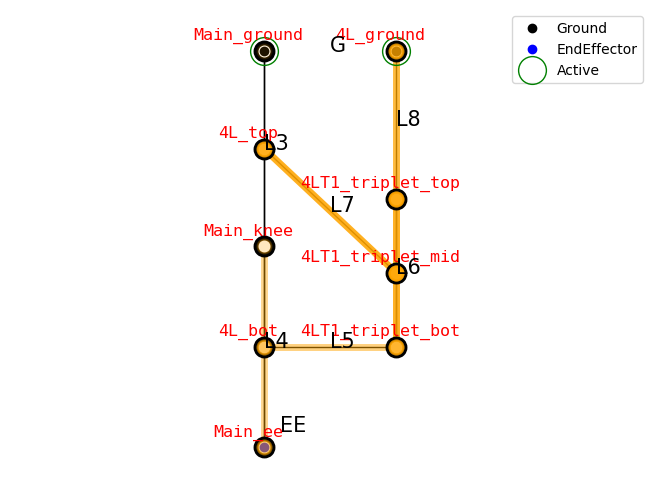

In [3]:
from auto_robot_design.description.actuators import TMotor_AK80_9

from auto_robot_design.description.mechanism import JointPoint2KinematicGraph
from auto_robot_design.description.utils import draw_links

kinematic_graph = JointPoint2KinematicGraph(graph_jp)
draw_links(kinematic_graph, graph_jp)
from auto_robot_design.description.utils import draw_kinematic_graph
# draw_kinematic_graph(kinematic_graph)
main_branch = kinematic_graph.define_main_branch()
# draw_kinematic_graph(main_branch)
kin_tree = kinematic_graph.define_span_tree()

thickness = 0.04
density = 2700 / 2.8

for n in kinematic_graph.nodes():
    n.thickness = thickness
    n.density = density

for j in kinematic_graph.joint_graph.nodes():
    j.pos_limits = (-np.pi, np.pi)
    if j.jp.active:
        j.actuator = TMotor_AK80_9()
    j.damphing_friction = (0.05, 0)
    
kinematic_graph.define_link_frames()

constraint_dict reduced: False
Starting workspace search for graph variants...
Current variant: {'Main_knee': (-0.1, 0, -0.248), '4L_ground': (-0.2, 0, -0.01), '4L_top': (-0.1, 0, -0.174), '4L_bot': (-0.1, 0, -0.32399999999999995), '4LT2_j0': (-0.19080761184457487, 0, -0.24851828996322964), '4LT2_j1': (-0.237, 0, -0.237), '4LT2_j2': (-0.2615182899632296, 0, -0.1961923881554251)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 122
unexplored: 222
unexplored: 384
unexplored: 642
unexplored: 0
Search took 14.679 seconds
-------------------
unexplored: 0
solutions: 724
3663 points remained after filtering out of 6400 points
Starting IK proximal...
Proximal took 74.6 seconds
Coverage of filtered xyz points: 0.277


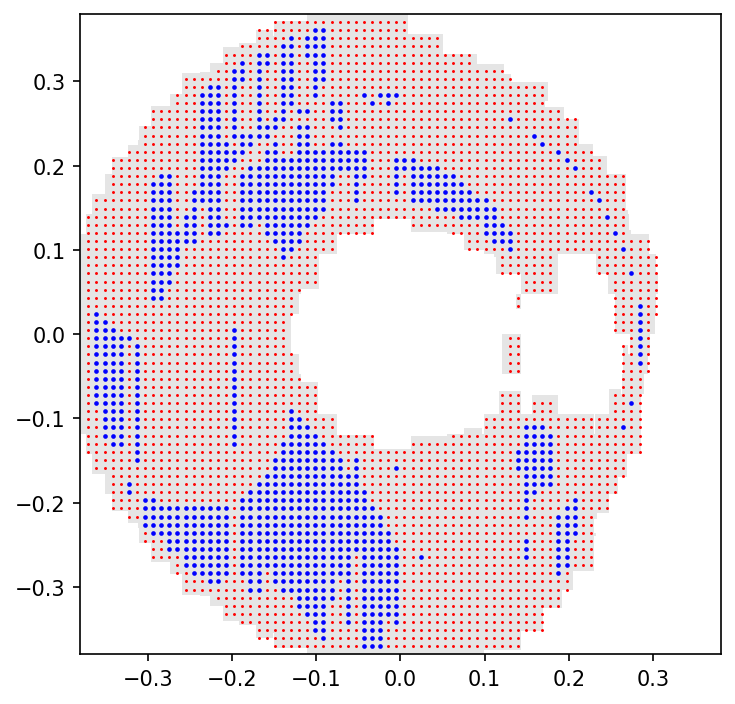

Search for 1 variants took 91.7 seconds


In [4]:
from testing_ground.singular_hell.workspace_run import WorkspaceRunner, reduce_constr_dict


cons_dict_reduced, is_changed = reduce_constr_dict(cons_dict, 10)
print(f'constraint_dict reduced: {is_changed}')
# print(cons_dict)

wr0 = WorkspaceRunner(graph_jp, cons_dict_reduced, j_divisions=1, is_using_FK=False, fname='g1')
# for n in list(wr0.graph.nodes()):
#     print(n.name, n.r)

# Choosing sigma:
# "splitselected" alg: 3*2/prox_divisions if 40+ divisions IK, if lower -> 2
# not using "splitselected" alg (or for FK prox): 2/5 - 2/10 (example: 2 for 160div FK is faster)
wr0.run(box_sigma=3*2/80, prox_divisions=80, is_using_prox_history=True, is_showing_points=True)

In [ ]:
# from testing_ground.singular_hell.workspace_run import WorkspaceLoader, kin_graph2pinocchio_robot

# wl = WorkspaceLoader(fname = 'g1')
# urdf_builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, thickness=0.015)

# for i,d in enumerate(wl.data):
#     if i%2 == 0: #variant
#         wl.mutate_graph(wl.restore_variant(d))

#         fig = plt.figure(figsize=(10,4.8), dpi=110)
#         ax = fig.add_subplot(1, 2, 1)
        
#         kinematic_graph = wl.prepare_kinematic_graph(is_showed=False)
#         draw_links(kinematic_graph, wl.graph)
#         # plt.show()

#         ee_b = calc_ee_range_of_2linker(kinematic_graph)

#     else: #points array
        
#         # ax = plt.gca()
#         ax2 = fig.add_subplot(1, 2, 2)

#         if wl.extra_data is not None:
#             ed = next(wl.extra_data)
#             plt.scatter(ed[:,0], ed[:,1],c='r',linewidths=0,s=2)
#         plt.scatter(d[:,0], d[:,1],c='b',linewidths=0,s=5)

#         plt.xlim(ee_b)
#         plt.ylim(ee_b)

#         ax2.set_aspect(1)
#         plt.tight_layout()
#         plt.show()
#         robo, _ = kin_graph2pinocchio_robot(kinematic_graph, urdf_builder)
#         viz = vis_robot(robo)
#         # hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [ ]:
plot_next_restored_variant(wl)
urdf_builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, thickness=0.015)
robo, _ = kin_graph2pinocchio_robot(kinematic_graph, urdf_builder)
viz = vis_robot(robo)

In [ ]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

Starting workspace search for graph variants...
Current variant: {'Main_knee': (-0.1, 0, -0.248), '4L_ground': (0.0, 0, -0.01)}


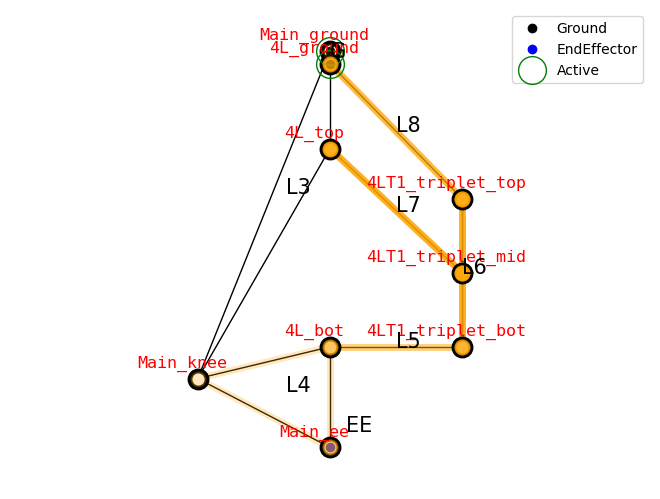

d:\soft\auto-robotics-design\auto_robot_design\description\builder.py:856: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  info_joint = self.creater.create_joint(joint)
d:\soft\auto-robotics-design\auto_robot_design\description\builder.py:933: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  return super().create_kinematic_graph(kinematic_graph, name)


Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 120
unexplored: 230
unexplored: 364
unexplored: 510
unexplored: 550
unexplored: 472
unexplored: 370
unexplored: 264
unexplored: 158
unexplored: 94
unexplored: 34
unexplored: 2
unexplored: 0
Search took 33.662 seconds
-------------------
unexplored: 0
solutions: 1319
9994 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 24.0 seconds
Coverage of filtered q points: 0.151


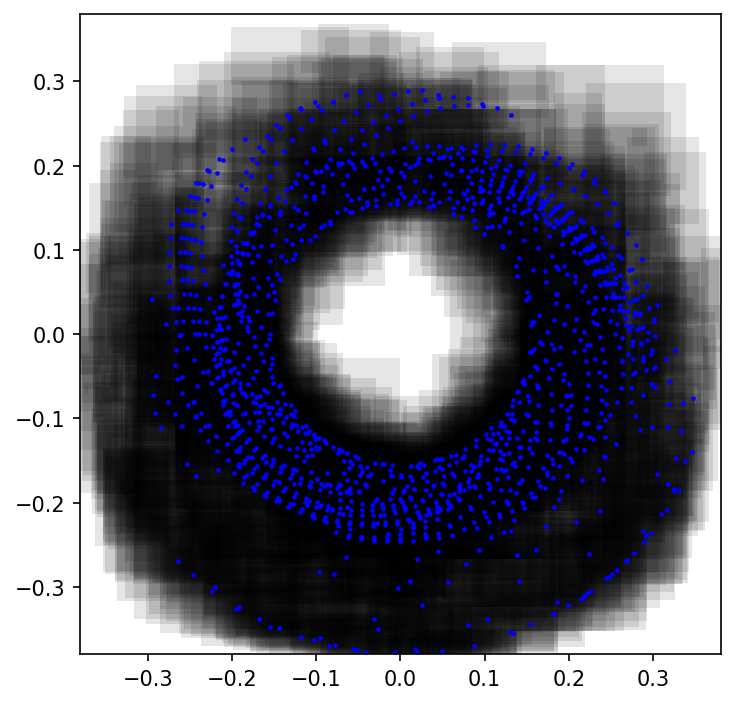

Current variant: {'Main_knee': (-0.1, 0, -0.248), '4L_ground': (0.0, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 124
unexplored: 216
unexplored: 316
unexplored: 368
unexplored: 344
unexplored: 272
unexplored: 182
unexplored: 92
unexplored: 22
unexplored: 4
unexplored: 2
unexplored: 0
Search took 23.702 seconds
-------------------
unexplored: 0
solutions: 880
9894 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 23.0 seconds
Coverage of filtered q points: 0.101
Current variant: {'Main_knee': (-0.1, 0, -0.248), '4L_ground': (0.2, 0, -0.01)}


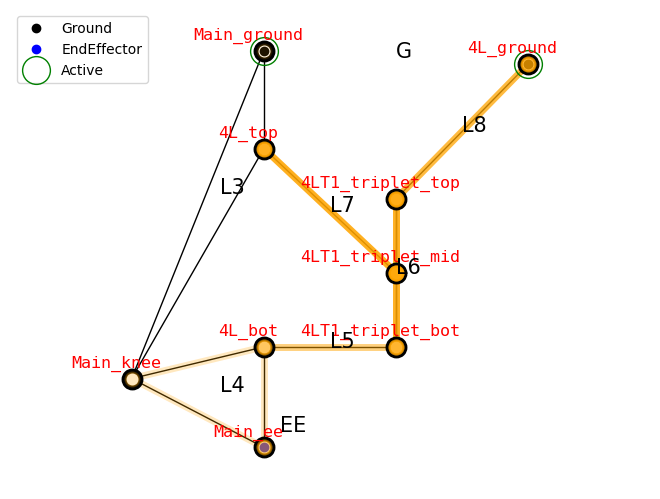

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 14
unexplored: 28
unexplored: 56
unexplored: 100
unexplored: 176
unexplored: 224
unexplored: 198
unexplored: 124
unexplored: 34
unexplored: 8
unexplored: 2
unexplored: 0
Search took 12.838 seconds
-------------------
unexplored: 0
solutions: 427
9811 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 24.4 seconds
Coverage of filtered q points: 0.079


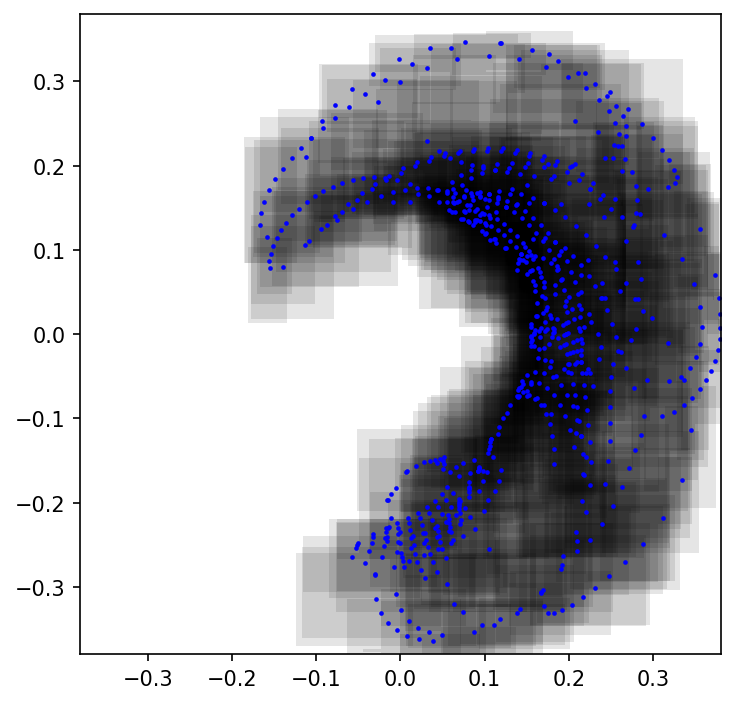

Current variant: {'Main_knee': (-0.1, 0, -0.248), '4L_ground': (0.2, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 128
unexplored: 228
unexplored: 242
unexplored: 166
unexplored: 76
unexplored: 12
unexplored: 4
unexplored: 0
Search took 14.668 seconds
-------------------
unexplored: 0
solutions: 435
9901 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 24.0 seconds
Coverage of filtered q points: 0.045
Current variant: {'Main_knee': (-0.1, 0, -0.04799999999999999), '4L_ground': (0.0, 0, -0.01)}


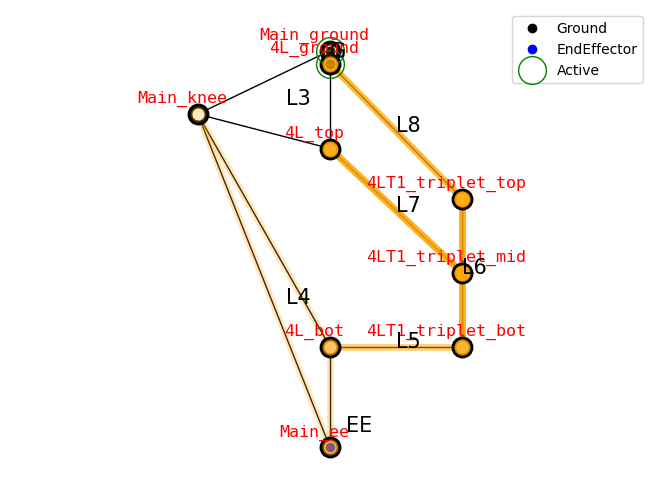

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 58
unexplored: 106
unexplored: 180
unexplored: 286
unexplored: 470
unexplored: 640
unexplored: 690
unexplored: 542
unexplored: 410
unexplored: 252
unexplored: 110
unexplored: 36
unexplored: 18
unexplored: 0
Search took 39.617 seconds
-------------------
unexplored: 0
solutions: 1700
9885 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 21.6 seconds
Coverage of filtered q points: 0.317


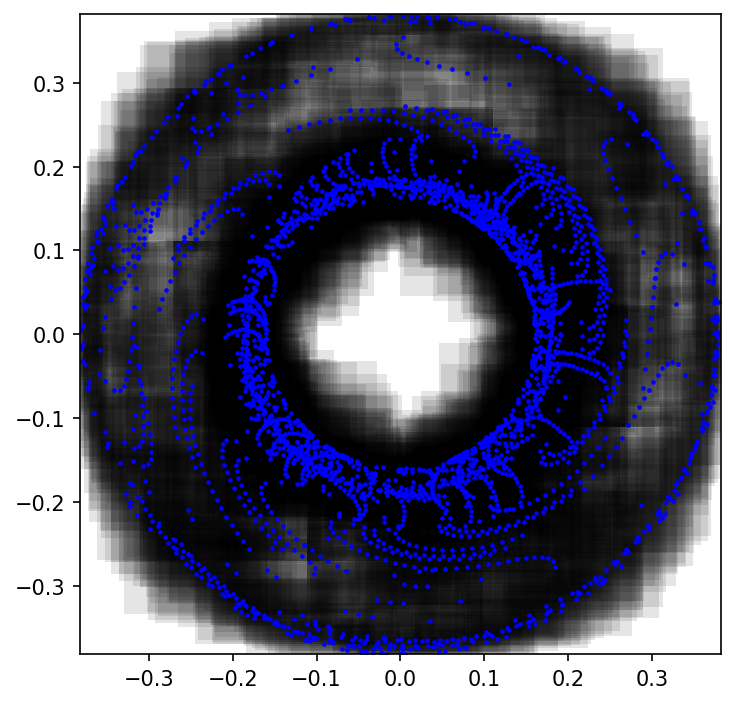

Current variant: {'Main_knee': (-0.1, 0, -0.04799999999999999), '4L_ground': (0.0, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 30
unexplored: 56
unexplored: 98
unexplored: 154
unexplored: 206
unexplored: 296
unexplored: 322
unexplored: 314
unexplored: 246
unexplored: 150
unexplored: 82
unexplored: 48
unexplored: 8
unexplored: 2
unexplored: 0
Search took 22.863 seconds
-------------------
unexplored: 0
solutions: 887
9993 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 26.1 seconds
Coverage of filtered q points: 0.156
Current variant: {'Main_knee': (-0.1, 0, -0.04799999999999999), '4L_ground': (0.2, 0, -0.01)}


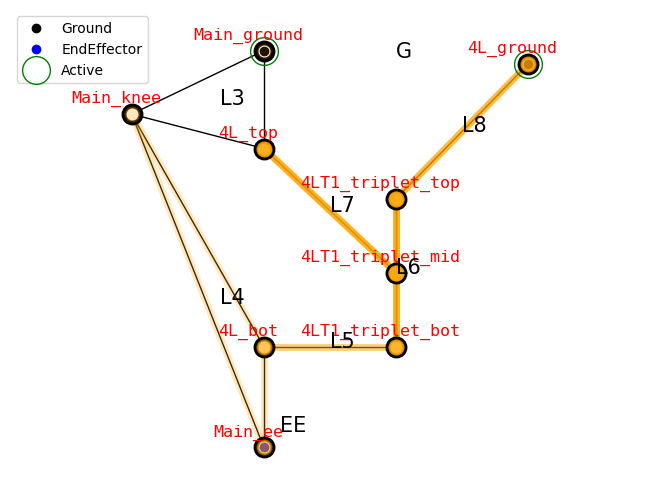

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 30
unexplored: 60
unexplored: 96
unexplored: 138
unexplored: 186
unexplored: 234
unexplored: 268
unexplored: 214
unexplored: 152
unexplored: 60
unexplored: 14
unexplored: 4
unexplored: 0
Search took 18.060 seconds
-------------------
unexplored: 0
solutions: 669
9916 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 22.8 seconds
Coverage of filtered q points: 0.155


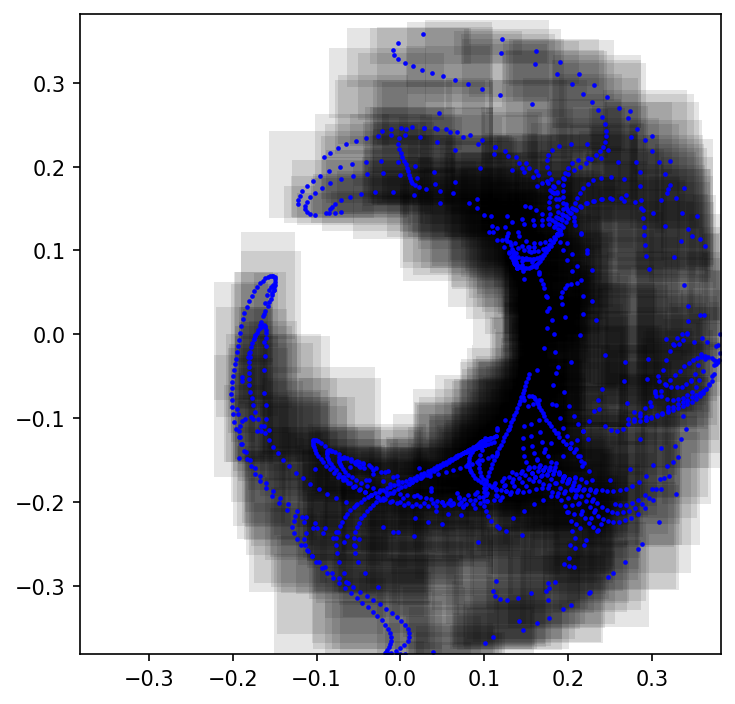

Current variant: {'Main_knee': (-0.1, 0, -0.04799999999999999), '4L_ground': (0.2, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 56
unexplored: 104
unexplored: 156
unexplored: 232
unexplored: 258
unexplored: 284
unexplored: 254
unexplored: 178
unexplored: 78
unexplored: 18
unexplored: 8
unexplored: 0
Search took 20.178 seconds
-------------------
unexplored: 0
solutions: 775
9900 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 26.1 seconds
Coverage of filtered q points: 0.104
Current variant: {'Main_knee': (0.1, 0, -0.248), '4L_ground': (0.0, 0, -0.01)}


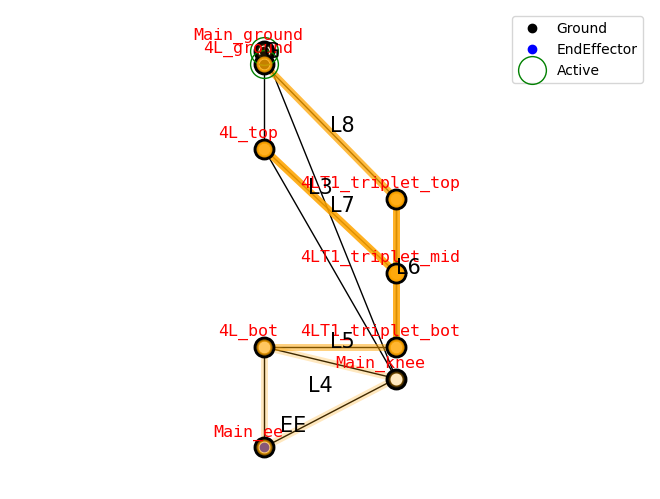

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 120
unexplored: 230
unexplored: 362
unexplored: 508
unexplored: 550
unexplored: 472
unexplored: 370
unexplored: 264
unexplored: 158
unexplored: 94
unexplored: 34
unexplored: 2
unexplored: 0
Search took 34.969 seconds
-------------------
unexplored: 0
solutions: 1322
9825 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 23.7 seconds
Coverage of filtered q points: 0.093


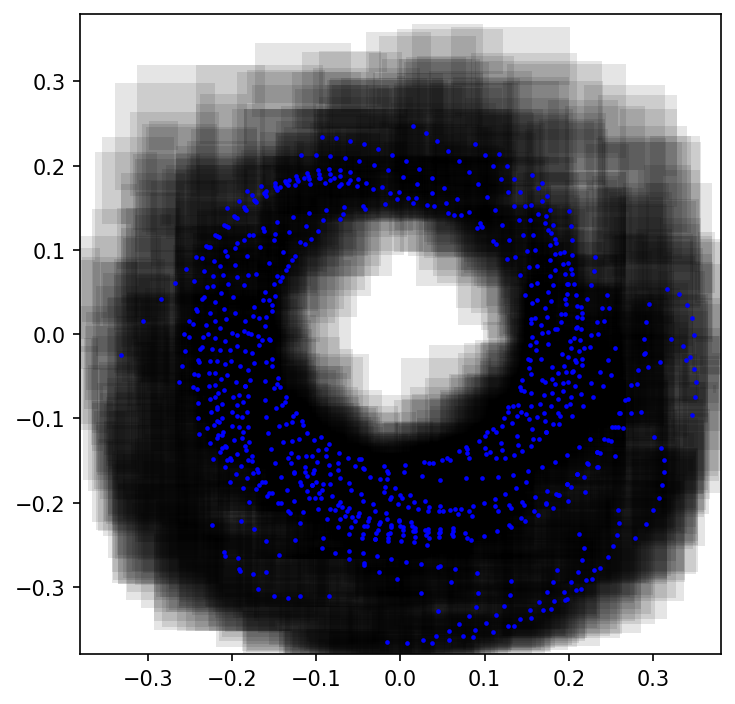

Current variant: {'Main_knee': (0.1, 0, -0.248), '4L_ground': (0.0, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 124
unexplored: 216
unexplored: 316
unexplored: 368
unexplored: 344
unexplored: 272
unexplored: 182
unexplored: 92
unexplored: 20
unexplored: 4
unexplored: 2
unexplored: 0
Search took 22.540 seconds
-------------------
unexplored: 0
solutions: 878
9906 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 23.2 seconds
Coverage of filtered q points: 0.100
Current variant: {'Main_knee': (0.1, 0, -0.248), '4L_ground': (0.2, 0, -0.01)}


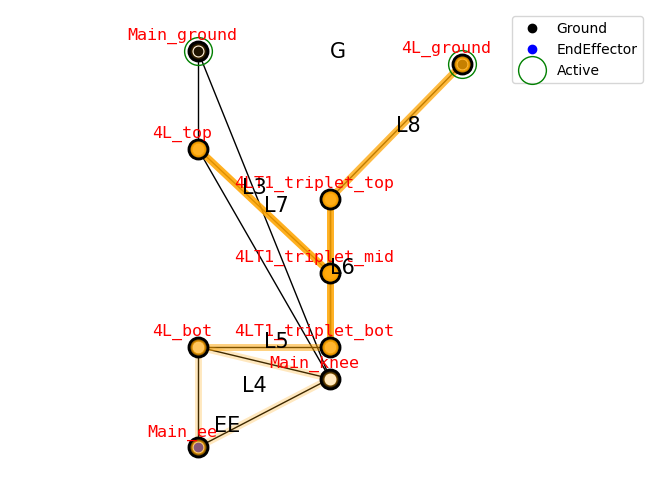

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 128
unexplored: 234
unexplored: 222
unexplored: 180
unexplored: 120
unexplored: 38
unexplored: 4
unexplored: 0
Search took 13.324 seconds
-------------------
unexplored: 0
solutions: 435
7470 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 19.3 seconds
Coverage of filtered q points: 0.092


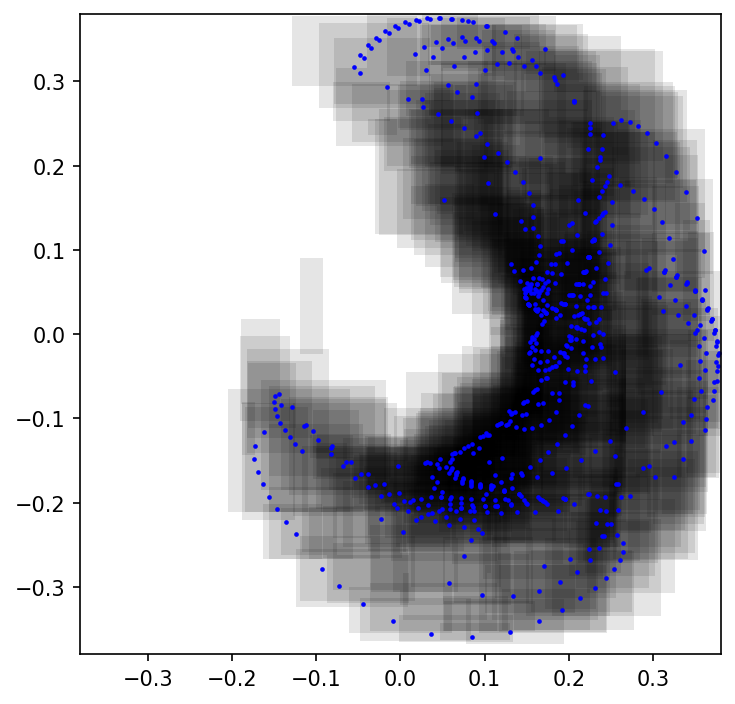

Current variant: {'Main_knee': (0.1, 0, -0.248), '4L_ground': (0.2, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 64
unexplored: 128
unexplored: 232
unexplored: 206
unexplored: 188
unexplored: 120
unexplored: 42
unexplored: 4
unexplored: 0
Search took 12.959 seconds
-------------------
unexplored: 0
solutions: 444
5488 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 14.2 seconds
Coverage of filtered q points: 0.076
Current variant: {'Main_knee': (0.1, 0, -0.04799999999999999), '4L_ground': (0.0, 0, -0.01)}


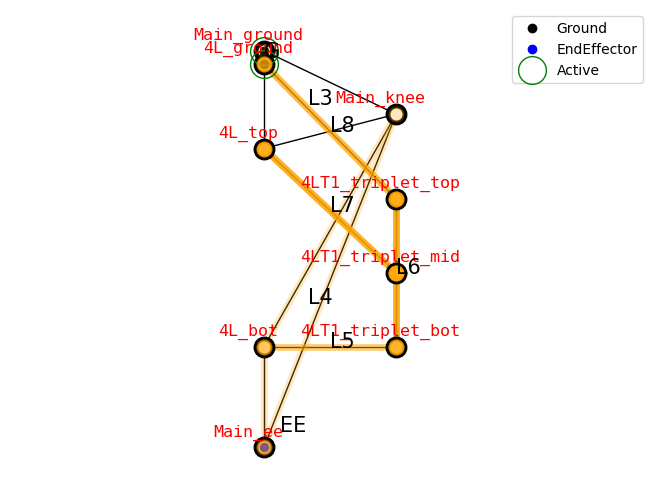

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 58
unexplored: 106
unexplored: 180
unexplored: 286
unexplored: 470
unexplored: 644
unexplored: 690
unexplored: 542
unexplored: 410
unexplored: 254
unexplored: 110
unexplored: 36
unexplored: 18
unexplored: 0
Search took 38.002 seconds
-------------------
unexplored: 0
solutions: 1705
9867 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 22.5 seconds
Coverage of filtered q points: 0.370


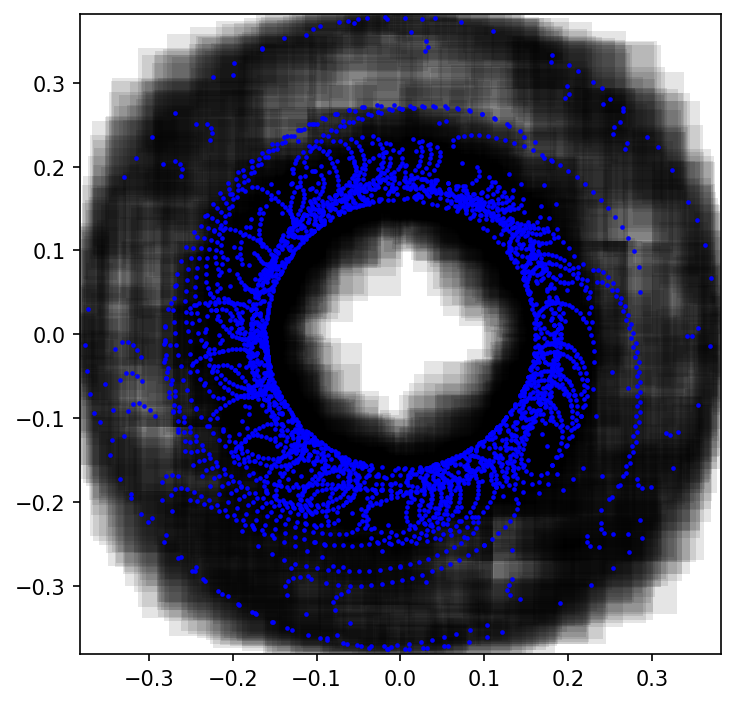

Current variant: {'Main_knee': (0.1, 0, -0.04799999999999999), '4L_ground': (0.0, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 30
unexplored: 56
unexplored: 98
unexplored: 154
unexplored: 206
unexplored: 296
unexplored: 322
unexplored: 314
unexplored: 246
unexplored: 152
unexplored: 82
unexplored: 48
unexplored: 8
unexplored: 2
unexplored: 0
Search took 22.707 seconds
-------------------
unexplored: 0
solutions: 890
9913 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 24.5 seconds
Coverage of filtered q points: 0.170
Current variant: {'Main_knee': (0.1, 0, -0.04799999999999999), '4L_ground': (0.2, 0, -0.01)}


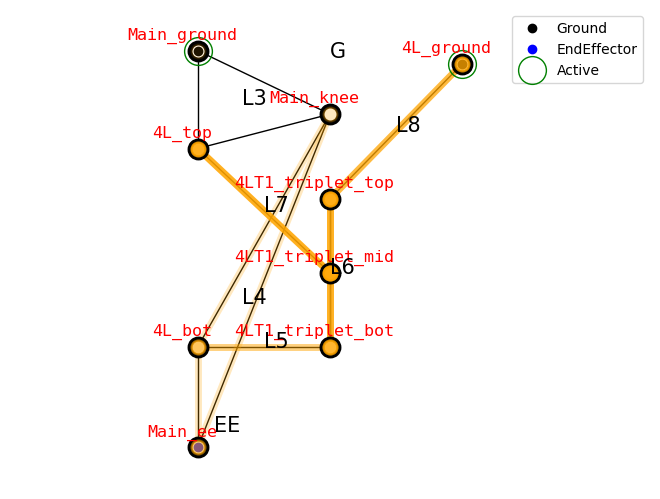

Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 32
unexplored: 54
unexplored: 88
unexplored: 126
unexplored: 186
unexplored: 244
unexplored: 256
unexplored: 258
unexplored: 148
unexplored: 48
unexplored: 24
unexplored: 2
unexplored: 0
Search took 17.133 seconds
-------------------
unexplored: 0
solutions: 659
7227 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 16.9 seconds
Coverage of filtered q points: 0.234


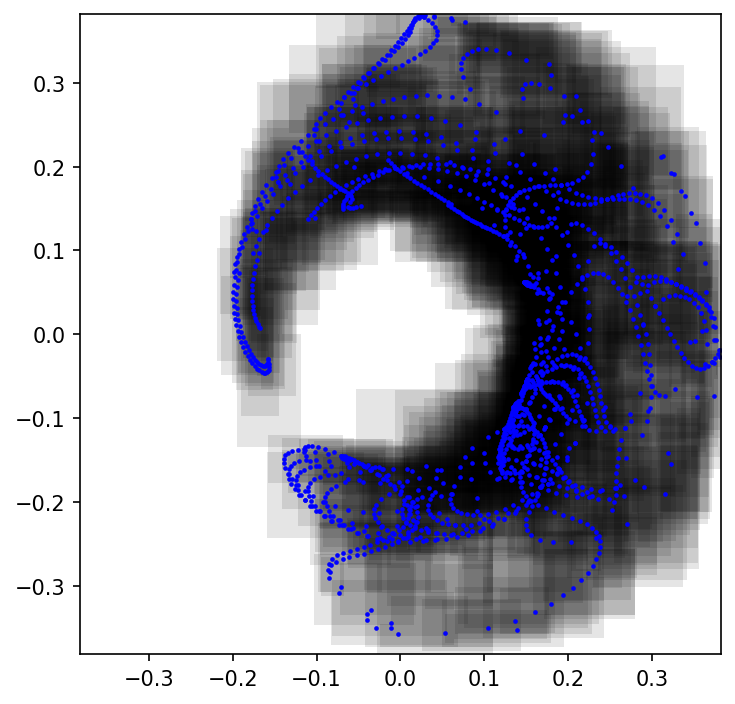

Current variant: {'Main_knee': (0.1, 0, -0.04799999999999999), '4L_ground': (0.2, 0, 0.1)}
Starting box approximation on 11 processes.
-------------------
unexplored: 1
unexplored: 2
unexplored: 4
unexplored: 8
unexplored: 16
unexplored: 30
unexplored: 54
unexplored: 96
unexplored: 148
unexplored: 212
unexplored: 282
unexplored: 282
unexplored: 254
unexplored: 164
unexplored: 78
unexplored: 26
unexplored: 2
unexplored: 0
Search took 19.357 seconds
-------------------
unexplored: 0
solutions: 748
6743 points remained after filtering out of 10000 points
Starting FK proximal...
Proximal took 16.2 seconds
Coverage of filtered q points: 0.166
Search for 16 variants took 739.4 seconds


In [4]:
from testing_ground.singular_hell.workspace_run import WorkspaceRunner, reduce_constr_dict
cons_dict_reduced, is_changed = reduce_constr_dict(cons_dict, 2)
# for k,v in cons_dict_reduced.items():
#     print(k,v)

wr = WorkspaceRunner(graph_jp, cons_dict_reduced, is_using_FK=True, j_divisions=2, fname='fk', is_using_date=False)
# for n in list(wr.graph.nodes()):
#     print(n.name, n.r)

# for v in wr.variants: #do not use for generators
#     print(v)
# print(len(wr.variants))

wr.run(box_sigma=2/5, prox_divisions=100, is_using_prox_history=True, 
       is_showing_graphs=True, is_showing_points=True, show_every_nth=2)

# for n in list(wr.graph.nodes()):
#     print(n.name, n.r)

In [ ]:
wl = WorkspaceLoader(fname = 'g')

for i,d in enumerate(wl.data):
    if i%2 == 0: #variant
        wl.mutate_graph(wl.restore_variant(d))
        kinematic_graph = wl.prepare_kinematic_graph(is_showed=False)
        ee_b = calc_ee_range_of_2linker(kinematic_graph)

    else: #points array
        fig = plt.figure(dpi=150)
        ax = plt.gca()

        plt.scatter(d[:,0], d[:,1],c='b',linewidths=0,s=5)

        plt.xlim(ee_b)
        plt.ylim(ee_b)

        ax.set_aspect(1)
        plt.tight_layout()
        plt.show()

In [ ]:
for n in list(graph_jp.nodes()):
    print(n.name, n.r)
#change mech

num_params_one_jp = len(x_opt) // len(opt_joints)
for id, jp in zip(range(0, len(x_opt), num_params_one_jp), opt_joints):
    xz = x_opt[id: (id + num_params_one_jp)]
    list_nodes = list(graph_jp.nodes())
    id = list_nodes.index(jp)
    list_nodes[id].r = np.array([xz[0], 0, xz[1]])
    # print(id,xz)

print('------------')
# print(list_nodes)

for n in list(graph_jp.nodes()):
    print(n.name, n.r)


In [ ]:
for n in list(graph_jp.nodes()):
    print(n.name, n.r)
print('------------')

gh = JPGraphHandler(graph_jp)
wl = WorkspaceLoader(fname = 'g')
gh.mutate_graph(wl.restore_variant(next(wl.data)))

for n in list(gh.graph.nodes()):
    print(n.name, n.r)
    

In [ ]:
# xl = np.array([-.5,.4])
# yl = np.array([-.5,.5])
# xb = [-.45,.3]
# yb = [-.45,.45]
ee_b = calc_ee_range_of_2linker(kinematic_graph)
xl = ee_b*1.25
yl = ee_b*1.25
xb = ee_b*1.5
yb = ee_b*1.5

x_span = xb[1]-xb[0]
y_span = yb[1]-yb[0]
print(ee_b)

In [ ]:
# max_span_divisor = 15
# np.max((x_span,y_span))/max_span_divisor
boxes, lname2id = box_workspace(kinematic_graph, 2/15, return_lorder=True)#, xb, yb)

In [ ]:
from itertools import product
from matplotlib.patches import Rectangle

from scipy.stats.qmc import PoissonDisk

def generate_points(boxes, x_ind, y_ind, step_size):
    # Find the minimum and maximum coordinates of all rectangles
    boxes2d = np.hstack(boxes)
    boxes2d = boxes2d[(x_ind,y_ind),:]
    x_min = np.min(boxes2d[0,:])#np.min(rect[0][0] for rect in rectangles2d)
    x_max = np.max(boxes2d[0,:])#np.max(rect[0][1] for rect in rectangles2d)
    y_min = np.min(boxes2d[1,:])#np.min(rect[1][0] for rect in rectangles2d)
    y_max = np.max(boxes2d[1,:])#np.max(rect[1][1] for rect in rectangles2d)

    print(x_min,x_max)
    print(y_min,y_max)
    # Generate a grid of 2D points with given step size
    sx = int((x_max -x_min)/step_size) +1
    sy = int((y_max -y_min)/step_size) +1
    # print(sx, sy)
    # print(-x_min+x_max)
    # print(-y_min+y_max)
    x_space = np.linspace(x_min, x_max, sx) 
    # y_space = np.linspace(y_min, y_max, sy)
    # x_space = np.arange(x_min, x_max, step_size) #TODO divisions
    y_space = np.arange(y_min, y_max, (x_max -x_min)/(sx-1))#step_size)
    points = np.asarray(list(product(x_space, y_space)))
    
    # sampler = PoissonDisk(2, radius=0.05, ncandidates=50)
    # points = (sampler.random(400)-0.5)*2*np.max((x_max,y_max))
    # print(points.T)
    # plt.scatter(points[:,0], points[:,1],c='r',linewidths=0,s=8)
    # # plt.xlim(xl)
    # # plt.ylim(yl)
    # ax.set_aspect(1)
    # plt.tight_layout()
    # plt.show()

    # print(points)
    # print(rectangles)
    # print(rectangles2d)
    # print(points)

    # x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    # points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

    # Check if each point lies inside any rectangle
    inside_rectangles = np.zeros(points.shape[0], dtype=bool)
    # print(inside_rectangles)
    for i in range(boxes2d.shape[1]//2):
        rect= boxes2d[:,(2*i,2*i+1)]
        # if rect[0,i+1] >
        #     print(rect)
        inside_rectangles |= (points[:, 0] >= rect[0,0]) & (points[:, 0] <= rect[0,1]) & (points[:, 1] >= rect[1,0]) & (points[:, 1] <= rect[1,1])
    # print(inside_rectangles)
    return points[inside_rectangles]

In [ ]:
# x_ind = -2
# y_ind = -1


# rectangles = boxes.copy()#[[(1, 3), (2, 4)], [(4, 6), (3, 5)]]
# step_size = 0.03
# inliers = generate_points(rectangles, x_ind, y_ind, step_size)
# # print(inliers)

# xl = np.array([-.5,.4])
# yl = np.array([-.5,0.])

# fig = plt.figure(dpi=150)
# ax = plt.gca()

# #TODO ПОМНИМ ЧТО БЫВАЕТ НАХОДИТ РЕШЕНИЯ В КОРОБКЕ С некоторыми НУЛЕВЫМИ СТОРОНАМИ
# x_ind = -2
# y_ind = -1

# for b in boxes:#[::30]:
#     # print(b)
#     xlb, xub = b[x_ind,0], b[x_ind,1]
#     ylb, yub = b[y_ind,0], b[y_ind,1]
#     ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='none',facecolor='k',alpha=1.))
# plt.scatter(inliers[:,0], inliers[:,1],c='r',linewidths=0,s=8)

# plt.xlim(xl)
# plt.ylim(yl)

# ax.set_aspect(1)
# # ax.set_box_aspect(1)
# plt.tight_layout()

# plt.show()

In [ ]:
x_space = np.linspace(ee_b[0], ee_b[1], 80)
z_space = np.linspace(ee_b[0], ee_b[1], 80)
# z_space = np.arange(yb[0], yb[1], (x_max -x_min)/(sx-1))

xyz_space = [(x,0,z) for x,z in list(product(x_space, z_space))]
# xyz_space2d = list(product(x_space, z_space))

In [ ]:
points = np.asarray(xyz_space)[:,(0,2)]
x_ind = -2
y_ind = -1
inliers = filter_points2d_by_boxes(boxes, x_ind, y_ind, points)
# print(inliers)

fig = plt.figure(dpi=150)
ax = plt.gca()

for b in boxes:#[::10]:
    xlb, xub = b[x_ind,0], b[x_ind,1]
    ylb, yub = b[y_ind,0], b[y_ind,1]
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='none',facecolor='k',alpha=.1))
# plt.scatter(inliers[:,0], inliers[:,1],c='r',linewidths=0,s=1)
plt.scatter(points[:,0], points[:,1],c='r',linewidths=0,s=1)

plt.xlim(xl)
plt.ylim(yl)

ax.set_aspect(1)
plt.tight_layout()

plt.show()

In [ ]:
import modern_robotics as mr


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE)
robomod, _ = jps_graph2pinocchio_robot(graph_jp, builder)
print(robomod.actuation_model.motname2id_q)

# jname2lnames = {}
# for j,e in kinematic_graph.joint2edge.items():
#     jname2lnames[j.jp.name] = [l.name for l in e]

jname2Rq0 = {}
for k,v in robomod.actuation_model.motname2id_q.items():
    j = kinematic_graph.name2joint[k]
    ln1, ln2 = j.link_in.name, j.link_out.name #jname2lnames[k]
    R1, _ = mr.TransToRp(kinematic_graph.name2link[ln1].frame)
    R2, _ = mr.TransToRp(kinematic_graph.name2link[ln2].frame)
    Rq0 = R1 @ R2.T
    jname2Rq0[k] = ((lname2id.get(ln1), lname2id.get(ln2)), (Rq0[0,0], Rq0[0,2])) #cos, sin from Ry

print(jname2Rq0)

In [ ]:
from testing_ground.singular_hell.box_utils import atan2_intervals, mul_intervals, subtr_intervals, gain_interval


def plot_boxes_qmot(boxes, lid_pair1, lid_pair2, Rq01, Rq02):
    inp = boxes.copy()

    w = 6
    def get_cos(box, lid):
        return box[w*lid+2, :] if lid is not None else np.array((1.,1.))

    def get_sin(box, lid):
        return box[w*lid+3, :] if lid is not None else np.array((0.,0.))

    lid1 = lid_pair1[0] 
    lid2 = lid_pair1[1]
    lid3 = lid_pair2[0]
    lid4 = lid_pair2[1]

    fig = plt.figure(dpi=150)
    ax = plt.gca()

    boxes_qmot = []
    q10 = np.arctan2(Rq01[1], Rq01[0])
    q20 = np.arctan2(Rq02[1], Rq02[0])
    print(q10/np.pi*180, q20/np.pi*180)

    for b in inp:#[::10]:
        # atang1 = atan2_intervals(b[sin_ind1,:],b[cos_ind1,:])
        # atang2 = atan2_intervals(b[sin_ind2,:],b[cos_ind2,:])           
        # xlb, xub = atang1# - (np.sign(atang1)-np.ones(2))*np.pi
        # ylb, yub = atang2# - (np.sign(atang2)-np.ones(2))*np.pi

        cosq1 = mul_intervals(get_cos(b,lid1), get_cos(b,lid2)) + mul_intervals(get_sin(b,lid1), get_sin(b,lid2))
        sinq1 = subtr_intervals(mul_intervals(get_sin(b,lid1), get_cos(b,lid2)), mul_intervals(get_cos(b,lid1), get_sin(b,lid2)))
        cosq2 = mul_intervals(get_cos(b,lid3), get_cos(b,lid4)) + mul_intervals(get_sin(b,lid3), get_sin(b,lid4))
        sinq2 = subtr_intervals(mul_intervals(get_sin(b,lid3), get_cos(b,lid4)), mul_intervals(get_cos(b,lid3), get_sin(b,lid4)))

        # cosq1_shift = gain_interval(cosq1,Rq01[0]) + gain_interval(sinq1,Rq01[1])
        # sinq1_shift = subtr_intervals(gain_interval(sinq1,Rq01[0]), gain_interval(cosq1,Rq01[1]))
        # cosq2_shift = gain_interval(cosq2,Rq02[0]) + gain_interval(sinq2,Rq02[1])
        # sinq2_shift = subtr_intervals(gain_interval(sinq2,Rq02[0]), gain_interval(cosq2,Rq02[1]))

        atang1 = atan2_intervals(sinq1,cosq1)  +q10
        atang2 = atan2_intervals(sinq2,cosq2)  +q20     
        boxes_qmot.append(np.vstack((atang1, atang2)))

        xlb, xub = atang1# - (np.sign(atang1)-np.ones(2))*np.pi
        ylb, yub = atang2# - (np.sign(atang2)-np.ones(2))*np.pi

        ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='none',facecolor='k',alpha=.1))
    
    ax.set_xlim([-2*np.pi,2*np.pi])
    ax.set_ylim([-2*np.pi,2*np.pi])

    ax.set_aspect(1)

    # for ii in xrange(0,360,1):
    #     ax.view_init(elev=10., azim=ii)
    #     savefig("movie%d.png" % ii)

    plt.show()
    return boxes_qmot

In [ ]:
# lname2id[] #3 8
# ln_pairs = [([lname2id.get(ln) for ln in jname2lnames[n]], jname2Rq0[n]) for n in robomod.actuation_model.motname2id_q.keys()]
# plot_boxes_qmot(boxes, lid_pairs[0][0], lid_pairs[1][0], lid_pairs[0][1], lid_pairs[1][1])
lid_pairs = list(jname2Rq0.values()) #TODO add sorting as in q vector
print(lid_pairs)

boxes_qmot = plot_boxes_qmot(boxes, lid_pairs[0][0], lid_pairs[1][0], lid_pairs[0][1], lid_pairs[1][1])

In [ ]:
q_space_mot_1 = np.linspace(-2*np.pi, 2*np.pi, 80*2, endpoint=False)
q_space_mot_2 = np.linspace(-2*np.pi, 2*np.pi, 80*2, endpoint=False)
qm = []
for i, m1 in enumerate(q_space_mot_1): 
    for j, m2 in enumerate(q_space_mot_2[::-1] if i%2 else q_space_mot_2):
        qm.append((m1, m2))
q_mot_double_space = qm
# q_mot_double_space = list(product(q_space_mot_1, q_space_mot_2))

qpoints = np.asarray(q_mot_double_space)

x_ind = 0
y_ind = 1
inliers = filter_points2d_by_boxes(boxes_qmot, x_ind, y_ind, qpoints)
# print(inliers)

fig = plt.figure(dpi=150)
ax = plt.gca()

for b in boxes_qmot:
    xlb, xub = b[x_ind,0]/np.pi*180, b[x_ind,1]/np.pi*180
    ylb, yub = b[y_ind,0]/np.pi*180, b[y_ind,1]/np.pi*180
    ax.add_patch(Rectangle((xlb,ylb),xub-xlb,yub-ylb,linewidth=1/2,edgecolor='none',facecolor='k',alpha=.1))
plt.scatter(inliers[:,0]/np.pi*180, inliers[:,1]/np.pi*180,c='r',linewidths=0,s=1)
# plt.scatter(qpoints[:,0], qpoints[:,1],c='r',linewidths=0,s=1)
# plt.scatter(inliers[:,0], inliers[:,1],c='b',linewidths=0,s=3)

# plt.xlim((-2*np.pi, 2*np.pi))
# plt.ylim((-2*np.pi, 2*np.pi))
# plt.xticks(np.arange(-180, 181, step=45))
# plt.yticks(np.arange(-180, 181, step=45))

ax.set_aspect(1)
plt.tight_layout()

plt.show()

In [ ]:
q_mot_double_space_filtered = np.column_stack((inliers[:,0], inliers[:,1]))
print(f'{q_mot_double_space_filtered.shape[0]} points remained after filtering out of {np.asarray(q_mot_double_space).shape[0] // 4} points')

workspace_xyz, available_q, jacs6d, jacsC6d, Ldsdq_6d = search_workspace_FK(robomod.model, robomod.data, EFFECTOR_NAME, BASE_FRAME, np.array(
    q_mot_double_space_filtered), robomod.actuation_model, robomod.constraint_models, robomod.constraint_data, viz, None)
print("Coverage q filtered:", len(available_q)/(len(q_mot_double_space_filtered)))

In [ ]:
fig = plt.figure(dpi=150) #6.4 4.8
ax = fig.add_subplot(1, 1, 1)
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], linewidth=0, s=4)
plt.suptitle("EE space")
plt.xlabel("X")
plt.ylabel("Z")
ax.set_aspect(1)

plt.tight_layout()
plt.show()

In [ ]:
q_act = available_q[:,robomod.actuation_model.idqmot]

fig = plt.figure(dpi=150)
plt.suptitle("Motor space")
ax = fig.add_subplot(1, 1, 1)
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, linewidth=0, s=4)

plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
ax.set_aspect(1)
plt.tight_layout()
plt.show()

In [ ]:
hasattr(viz.viewer, 'jupyter_cell') and viz.viewer.jupyter_cell()

In [ ]:
# points = np.asarray(xyz_space)[:,(0,2)]
# x_span = xb[1]-xb[0]
# y_span = yb[1]-yb[0]
# max_span_divisor = 1.1

# boxes = box_workspace(kinematic_graph, np.max((x_span,y_span))/max_span_divisor, xb, yb)
# x_ind = -2
# y_ind = -1
# inliers = filter_points2d_by_boxes(boxes, x_ind, y_ind, points)

# xyz_space_filtered = np.column_stack((inliers[:,0], np.zeros(inliers.shape[0]), inliers[:,1]))
# print(f'{xyz_space_filtered.shape[0]} points remained after filtering out of {np.asarray(xyz_space).shape[0]} points')

# jointspace_q2, available_xyz2, jacsik6d2, jacsCik6d2 = search_workspace_IK(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.asarray(
#     xyz_space_filtered), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz)
# print(f"Coverage xyz filtered {len(available_xyz2)/len(xyz_space_filtered):.3f}")

In [ ]:
points = np.asarray(xyz_space)[:,(0,2)]

# boxes = box_workspace(kinematic_graph, 2)
x_ind = -2
y_ind = -1
inliers = filter_points2d_by_boxes(boxes, x_ind, y_ind, points)

xyz_space_filtered = np.column_stack((inliers[:,0], np.zeros(inliers.shape[0]), inliers[:,1]))
print(f'{xyz_space_filtered.shape[0]} points remained after filtering out of {np.asarray(xyz_space).shape[0]} points')

jointspace_q, available_xyz, jacsik6d, jacsCik6d = search_workspace_IK(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.asarray(
    xyz_space_filtered), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz)
print(f"Coverage xyz filtered {len(available_xyz)/len(xyz_space_filtered):.3f}")

In [ ]:
jointspace_q, available_xyz, jacsik6d, jacsCik6d = search_workspace_IK(robo.model, robo.data, EFFECTOR_NAME, BASE_FRAME, np.asarray(
    xyz_space), robo.actuation_model, robo.constraint_models, robo.constraint_data, viz)
print(f"Coverage xyz {len(available_xyz)/len(xyz_space):.3f}")

In [ ]:
svdsik = []
svds2ik = []
for Jclosed, Jc in zip(jacsik6d, jacsCik6d):
    Jmot,Jpassive = Jc[0]

    svd1, svdinv, _, _ = Jcl_toXZ_svds(Jclosed)

    svdsik.append(svd1)
    svds2ik.append(svdinv)

for i, (Jclosed, Jc) in enumerate(zip(jacsik6d, jacsCik6d)):
    Jmot,Jpassive = jacsCik6d[i][0]
    # print(Jmot)
    # print(Jpassive)
    dqdmot = calc_dqdmot(Jmot,Jpassive, robo.actuation_model)
    # print(dqdmot)
    dmotdq = np.linalg.pinv(dqdmot)
    u,s,vh = np.linalg.svd(dmotdq)
    svds2ik[i] = (u,s,vh)

singvalsik = np.empty(np.shape(available_xyz)[0])
singvals2ik = np.empty(len(singvalsik))
rsvecsik_q = np.empty((len(svdsik), np.shape(svdsik[0][2])[1]))
rsvecsik_ee = np.empty((len(svdsik), np.shape(svds2ik[0][2])[1]))

for i, (U, S, Vh) in enumerate(svdsik):
    singvalsik[i] = S[-1]
    U2, S2, Vh2 = svds2ik[i]
    # print(S2)
    singvals2ik[i] = S2[-1]
    # print(S,S2)
    rsvecsik_q[i,:] = Vh[-1,:]
    rsvecsik_ee[i,:] = Vh2[-1,:]



sing_proxik = 1/singvalsik
sing_prox2ik = 1/singvals2ik
# for s in singvals2ik:
#     print(s)


motorspace_q = jointspace_q[:,robo.actuation_model.idqmot]
# print(motorspace_q)
motorspace_q = angle_wrap(motorspace_q)
# print(motorspace_q)

In [ ]:
fig = plt.figure(figsize=(10, 4.8), dpi=150) #6.4 4.8
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
# plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='Spectral_r', norm='log', linewidth=0, alpha=0.3)
# plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='coolwarm', norm='log', linewidth=0, alpha=0.3)
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.suptitle("EE space")
plt.title("backward sigularities (type 1)")
plt.xlabel("X")
plt.ylabel("Z")
# plt.axis('equal')
ax.set_aspect(1)
plt.colorbar()
# vscale = 1/15
# plt.quiver(workspace_xyz[:, 0], workspace_xyz[:, 2], 
#            rsvecs_ee[:, 0]*vscale, rsvecs_ee[:, 1]*vscale, 
#            color=['w'], angles='xy', scale_units='xy', scale=1)
plt.tight_layout()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor((0., 0., 0.))
plt.scatter(workspace_xyz[:, 0],  workspace_xyz[:, 2], c=sing_prox2, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.title("forward sigularities (type 2)")
plt.xlabel("X")
plt.ylabel("Z")
# plt.axis('equal')
ax2.set_aspect(1)
plt.colorbar()
plt.tight_layout()

plt.show()

In [ ]:
def plot_pixels(fig, ax, data_x, data_y, colors, x_mindatastep, y_mindatastep, limsx=None, limsy=None):
    ax.set_facecolor((0., 0., 0.))
    fig.canvas.draw()

    st = x_mindatastep
    is_x = True
    if y_mindatastep < x_mindatastep:
        st = y_mindatastep
        is_x = False

    # plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='Spectral_r', norm='log', linewidth=0, s=18)
    # plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='BrBG', norm='log', linewidth=0, s=18) #'coolwarm'
    scat = plt.scatter(data_x, data_y, c=colors, cmap='RdBu_r', norm='log', linewidth=0, marker='s') # marker='s' s=18
    # plt.scatter(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, c=sing_prox, cmap='jet', norm='log', linewidth=0, s=18)
    
    # plt.axis('equal')
    if limsx is not None:
        plt.xlim(limsx)
    if limsy is not None:
        plt.ylim(limsy)
    plt.tight_layout()
    plt.colorbar()
    # ax.set_box_aspect(1)
    ax.set_aspect(1)
    xl=ax.get_xlim()
    yl=ax.get_ylim()
    w = abs(xl[0]-xl[1]) if is_x else abs(yl[0]-yl[1]) 
    msize = (( (ax.get_window_extent().width if is_x else ax.get_window_extent().height) * 72./fig.dpi / w*st) ** 2)
    scat.set_sizes([msize])

def calc_min_step(arr1D, threshold=0):
    d = np.diff(np.sort(arr1D))
    return d[d>threshold].min()

In [ ]:
stx = calc_min_step(q_act[:,0])/np.pi*180
sty = calc_min_step(q_act[:,1])/np.pi*180
# svds.append()
fig = plt.figure(figsize=(10, 4.8), dpi=150)
plt.suptitle("Motor space")
ax = fig.add_subplot(1, 2, 1)
plt.title("backward sigularities (type 1)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plot_pixels(fig, ax, q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, sing_prox, stx, sty)

# vscale = 10
# plt.quiver(q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, 
#            rsvecs_q[:, 0]*vscale, rsvecs_q[:, 1]*vscale, 
#            color=['g'], angles='xy', scale_units='xy', scale=1)
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))

ax2 = fig.add_subplot(1, 2, 2)
plt.title("forward sigularities (type 2)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plot_pixels(fig, ax2, q_act[:, 0]/np.pi*180, q_act[:, 1]/np.pi*180, sing_prox2, stx, sty)
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))

plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 4.8), dpi=150) #6.4 4.8
ax = fig.add_subplot(1, 2, 1)
ax.set_facecolor((0., 0., 0.))
plt.scatter(motorspace_q[:, 0]/np.pi*180,  motorspace_q[:, 1]/np.pi*180, c=sing_proxik, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.suptitle("Motor space")
plt.title("backward sigularities (type 1)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")

plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
plt.xlim([-180, 180])
plt.ylim([-180, 180])
# plt.axis('equal')
plt.colorbar()
ax.set_aspect(1)
# vscale = 6
# plt.quiver(motorspace_q[:, 0]/np.pi*180, motorspace_q[:, 1]/np.pi*180, 
#            rsvecsik_q[:, 0]*vscale, rsvecsik_q[:, 1]*vscale, 
#            color=['w'], angles='xy', scale_units='xy', scale=1)
plt.tight_layout()

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_facecolor((0., 0., 0.))
plt.title("forward sigularities (type 2)")
plt.xlabel("m1 angle, degrees")
plt.ylabel("m2 angle, degrees")
plt.scatter(motorspace_q[:, 0]/np.pi*180,  motorspace_q[:, 1]/np.pi*180, c=sing_prox2ik, cmap='RdBu_r', norm='log', linewidth=0,  alpha=0.5)
plt.xticks(np.arange(-180, 181, step=45))
plt.yticks(np.arange(-180, 181, step=45))
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.colorbar()
ax.set_aspect(1)

plt.tight_layout()
plt.show()

In [ ]:
stx = calc_min_step(available_xyz[:,0], 1e-6)
sty = calc_min_step(available_xyz[:,2], 1e-6)

fig = plt.figure(figsize=(10, 4.8), dpi=150)
plt.suptitle("EE space")
ax = fig.add_subplot(1, 2, 1)
plt.title("backward sigularities (type 1)")
plt.xlabel("X")
plt.ylabel("Z")
plot_pixels(fig, ax, available_xyz[:,0], available_xyz[:,2], sing_proxik, stx, sty)

# vscale = 1/20#10
# plt.quiver(available_xyz[:,0], available_xyz[:,2], 
#            rsvecsik_ee[:, 0]*vscale, rsvecsik_ee[:, 1]*vscale, 
#            color=['k'], angles='xy', scale_units='xy', scale=1)

ax2 = fig.add_subplot(1, 2, 2)
plt.title("forward sigularities (type 2)")
plt.xlabel("X")
plt.ylabel("Z")
plot_pixels(fig, ax2, available_xyz[:,0], available_xyz[:,2], sing_prox2ik, stx, sty)

plt.show()